In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal, uniform, choice, randint
from numpy import pi
import sys, shutil
from tqdm import tqdm
from deeptracktorch.disp import *
from deeptracktorch.simg import *
from deeptracktorch.fastai_adapter import *
from deeptracktorch.measures import radialcenter
from deeptracktorch.models import DeepTrackNet
from deeptracktorch.video import track_single_particle

from fastai.vision import *
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Experiment 1: Extract Particle Position From Images of Single Particles
> An experiment to train NN to extract position of particle from image conatining 1 particle.

## Introduction

The aim of this notebook is to demonstrate the process of training a Neural Network to extract the position of a particle from an image.

It will only consider images containing a single particle.

The stages are as follows:
 * Generate a set of synthetic images: Training, Validation and Test Sets
 * Define a DataLoader for this training data.
 * Load our Neural Network architecture and train the network
 * Use the trained network to extract the position of particles in the test set
 * Evaluate the accuracy of the extractions
 * (consider hyperparameters)

## Import the pre-trained network

The networks were trained on colab instance. See training notebooks [TODO]


In [ ]:
basic_learner = load_learner('models/100k/1p_close')
basic_learner_w_zero_particles = load_learner('models/100k/01p_close')
multi_learner = load_learner('models/100k/05p_close')

AttributeError: Can't get attribute 'MImageList' on <module 'deeptracktorch.simg' from '/Users/wooduk/projects/DeepTrack/deeptrack/nbs/deeptracktorch/simg.py'>

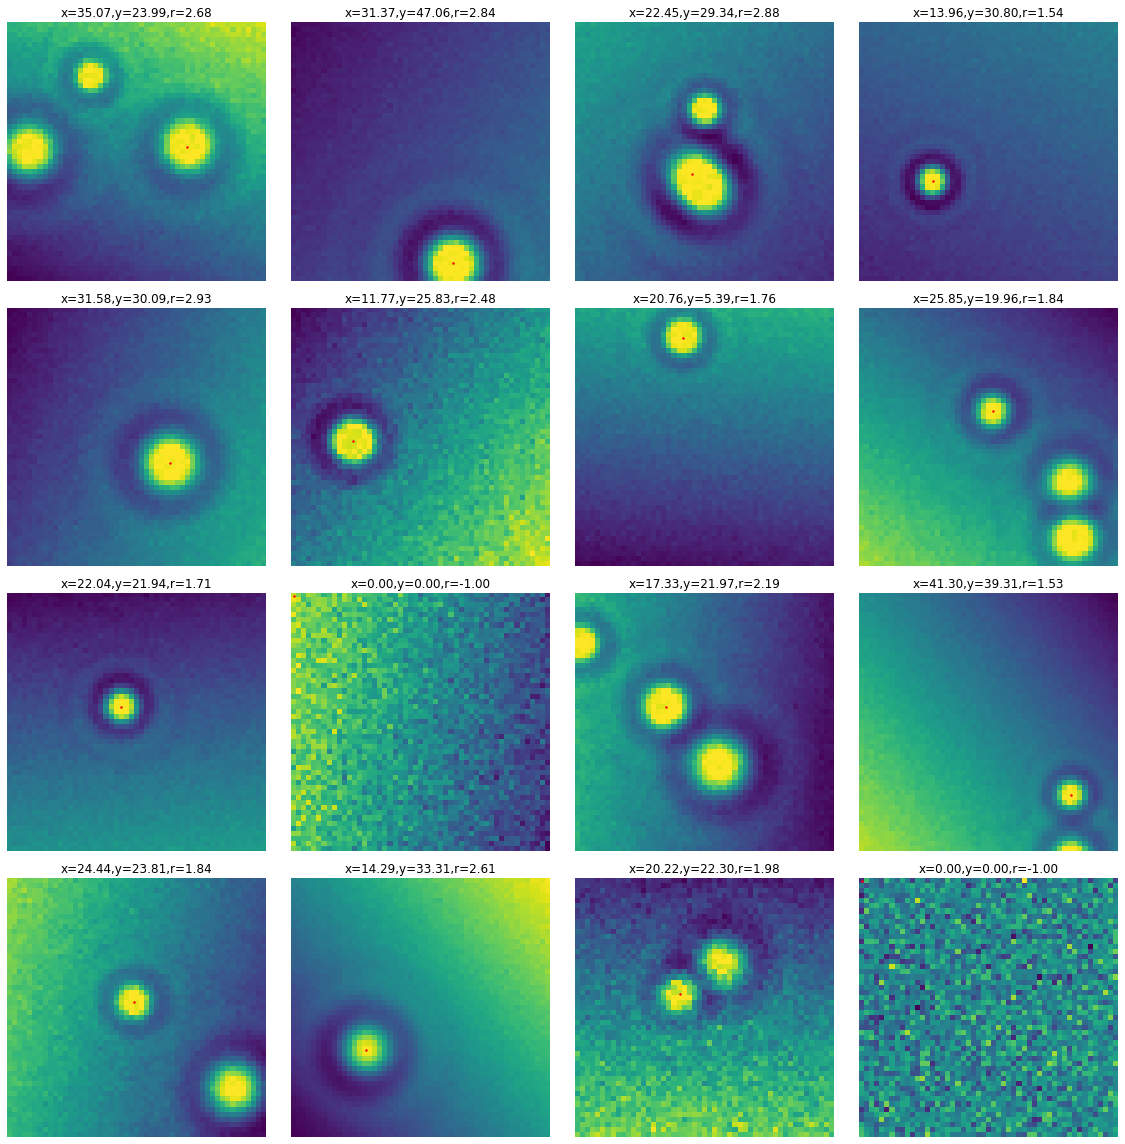

In [ ]:
batch_size=16
data=MImageList.from_df(train_specs_df).split_by_rand_pct(0.2).label_from_df(cols=['tx','ty','tr'],label_cls = XYRList).databunch(bs=batch_size)
data.show_batch()

Create a `Learner` (fastai concept that combines data and netwrok).

In [ ]:
learner = Learner(data, DeepTrackNet)

And train it...

In [ ]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,time
0,11.541556,7.641209,01:08
1,8.524967,7.105650,01:40
2,7.188013,6.257894,02:16
3,6.609187,6.214166,01:17


And save the trained network

In [ ]:
learner.export()

## If not training the network...

Load in a pre-trained network

In [ ]:
learner = load_learner('models/E1a')

/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/wooduk/projects/DeepTrack/venv/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve t

## Evaluate the accuracy of predictions compared to standard methods

### Performance for varying levels of SNR

Set up experimental parameters

In [ ]:
train_img_dist = {   
    'n_particles': lambda: 1,
    'size': lambda: 51,
    'bkgd_level': lambda: uniform(0.2,0.8),
    'gradient_intensity': lambda: uniform(0,1),
    'gradient_direction': lambda: uniform(-pi,pi),
    'snr': lambda: uniform(10,100),
}

train_p_dist = {
    # the position of the particle relative to center of image. -1 to +1 being the edges in each direction.
    'x': lambda: normal(0., 0.5),
    'y': lambda: normal(0., 0.5),
    
    # I don't know what units this is in... pixels?
    'radius': lambda: uniform(1.5, 3),
    'intensities': lambda: [uniform(.7, .9, 1), -uniform(.2, .3, 1)],
    'bessel_orders': lambda: [1, 2]    ,
    'ellip_direction': lambda: uniform(-pi, pi),
    'ellipticity':  lambda: 1,
}

Now loop through SNR values and evaluate predictions, record results

In [ ]:
MAE_snr_dtt=[]
MAE_snr_sym=[]

for snr in np.logspace(np.log10(3),np.log10(80), num=15):
    # fix the snr
    train_img_dist['snr'] = lambda : snr
    
    # produce 1000 images at this SNR
    test_df = define_image(train_img_dist, train_p_dist, 100)
    test_df = add_target(test_df)
    
    test_images = MImageList.from_df(test_df)
    test_truth = test_df[['tx','ty','tr']].to_numpy()
    
    # try depptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    MAE_snr_dtt += [[snr, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_snr_sym += [[snr, mean_absolute_error(test_truth, sym_preds)]]


import pickle
with open('snr_results_2.pkl','wb') as f:
    pickle.dump((MAE_snr_dtt,MAE_snr_sym),f)
   

### Performance for varying background gradient intensities

Set up experimental parameters

In [ ]:


giexp_img_dist = {   
    'n_particles': lambda: 1,
    'size': lambda: 51,
    'bkgd_level': lambda: uniform(0.2,0.8),
    'gradient_intensity': lambda: 0,
    'gradient_direction': lambda: uniform(-pi,pi),
    'snr': lambda: 50,
}

giexp_p_dist = {
    # the position of the particle relative to center of image. -1 to +1 being the edges in each direction.
    'x': lambda: normal(0., 0.01),
    'y': lambda: normal(0., 0.01),
    
    # I don't know what units this is in... pixels?
    'radius': lambda: uniform(1.5, 3),
    'intensities': lambda: [choice([-1, 1]) * uniform(.2, .6,)], #[uniform(.7, .9, 1), -uniform(.2, .3, 1)],
    'bessel_orders': lambda: [randint(1,3)]    ,
    'ellip_direction': lambda: uniform(-pi, pi),
    'ellipticity':  lambda: 1,
}


Now loop through SNR values and evaluate predictions, record results

In [ ]:
MAE_gi_dtt=[]
MAE_gi_sym=[]

for gi in np.linspace(0,1, num=11):
    # fix the snr
    giexp_img_dist['gradient_intensity'] = lambda : gi
    
    # produce 1000 images at this SNR
    test_df = define_image(giexp_img_dist, giexp_p_dist, 100)
    tr_cols = set(test_df.columns)
    MAX_TARGETS_PER_IMAGE = 1 
    test_df = add_target(test_df)
     
    # try depptracktorch
    dtt_preds = np.array([learner.predict(x)[1].numpy() for x in test_images])
    
    # try symterical
    sym_preds = np.array([radialcenter(x.px.squeeze())[:3] for x in test_images])
    
    MAE_gi_dtt += [[gi, mean_absolute_error(test_truth, dtt_preds)]]
    MAE_gi_sym += [[gi, mean_absolute_error(test_truth, sym_preds)]]

import pickle
with open('gi_results_2.pkl','wb') as f:
    pickle.dump((MAE_gi_dtt,MAE_gi_sym),f)

### Plot results

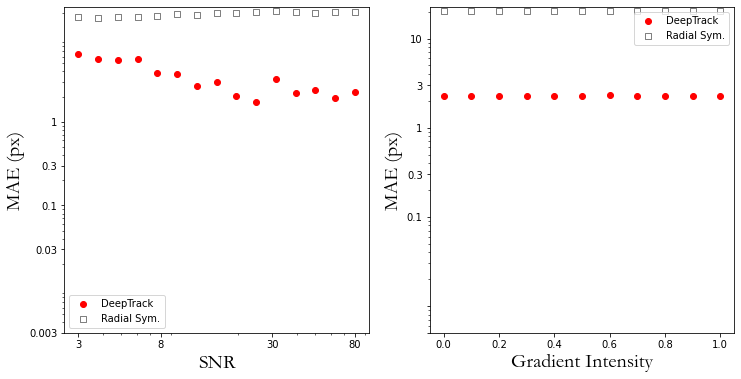

In [ ]:
with open('snr_results_2.pkl','rb') as f:
    Md_snr,Ms_snr = pickle.load(f)

with open('gi_results_2.pkl','rb') as f:
    Md_gi,Ms_gi = pickle.load(f)

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(x=np.array(Md_snr)[:,0],y=np.array(Md_snr)[:,1],label='DeepTrack',marker='o',c='r')
ax[0].scatter(x=np.array(Ms_snr)[:,0],y=np.array(Ms_snr)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xticks([3,8,30,80])
ax[0].set_xticklabels([3,8,30,80])
ax[0].set_yticks([0.003,0.03,0.1,0.3,1])
ax[0].set_yticklabels([0.003,0.03,0.1,0.3,1])
ax[0].set_xlabel('SNR', fontsize=20, fontfamily='Garamond')
ax[0].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[0].legend()

# Gradient Intensity Plot
ax[1].scatter(x=np.array(Md_gi)[:,0],y=np.array(Md_gi)[:,1],label='DeepTrack',marker='o',c='r')
ax[1].scatter(x=np.array(Ms_gi)[:,0],y=np.array(Ms_gi)[:,1],label='Radial Sym.',marker='s',ec='grey',fc='none')
ax[1].set_yscale('log')
ax[1].set_yticks([0.005,0.01,0.1,0.3,1,3,10])
ax[1].set_yticklabels(['','',0.1,0.3,1,3,10])
ax[1].set_xlabel('Gradient Intensity', fontsize=20,fontfamily='Garamond')
ax[1].set_ylabel('MAE (px)', fontsize=20,fontfamily='Garamond')
ax[1].legend()

In [ ]:
# take the predicted positions and compare to symtry method
video_file_name = '../../DeepTrack 1.0/DeepTrack - Example 2 - Optically Trapped Particle Bad.mp4'

estimators = {
        'deeptrack':lambda image: learner.predict(npimg2tensor(image))[1].numpy(),
        'symmetry':lambda image: np.array(radialcenter(image)[:3],dtype=np.float32),
    }

predicted_positions = track_single_particle(
    video_file_name, 
    estimators,use_cv2=False)

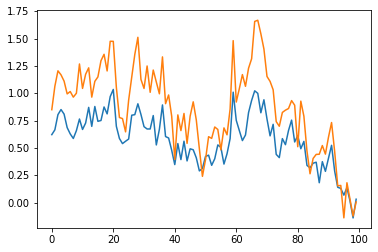

In [ ]:
plt.plot(predicted_positions['deeptrack'][:,1])
plt.plot(predicted_positions['symmetry'][:,1])
